In [1]:
import pandas as pd
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import requests
import plotly.express as px
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import networkx as nx
from collections import Counter


pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', lambda x: f'%.{2}f' % x)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('../8Jul2020-14Jul2020.csv')
df['Date'] = pd.to_datetime(df['Start Date'], dayfirst=True)
df.sort_values(by='Date', inplace=True)
df['Date'] = df['Date'].dt.date
df[df['Duration'] >= 10000] = np.NaN
df = df.dropna()
df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,EndStation lat,EndStation long,EndStation nbBikes,EndStation nbStandardBikes,EndStation nbEBikes,EndStation nbEmptyDocks,EndStation nbDocks,StartStation lat,StartStation long,StartStation nbBikes,StartStation nbStandardBikes,StartStation nbEBikes,StartStation nbEmptyDocks,StartStation nbDocks,Date
0,99188805.00,780.00,13656.00,08/07/2020 00:13,476.00,"Stebondale Street, Cubitt Town",08/07/2020 00:00,532.00,"Jubilee Plaza, Canary Wharf",51.49,-0.01,26.00,24.00,2.00,3.00,29.00,51.50,-0.02,46.00,45.00,1.00,17.00,63.00,2020-07-08
1,99188806.00,180.00,4393.00,08/07/2020 00:03,531.00,"Twig Folly Bridge, Mile End",08/07/2020 00:00,517.00,"Ford Road, Old Ford",51.53,-0.04,6.00,6.00,0.00,15.00,21.00,51.53,-0.03,2.00,2.00,0.00,16.00,18.00,2020-07-08
2,99188809.00,960.00,8973.00,08/07/2020 00:17,508.00,"Fournier Street, Whitechapel",08/07/2020 00:01,779.00,"Houndsditch, Aldgate",51.52,-0.07,8.00,8.00,0.00,10.00,18.00,51.51,-0.08,3.00,3.00,0.00,25.00,28.00,2020-07-08
3,99188810.00,960.00,7141.00,08/07/2020 00:17,508.00,"Fournier Street, Whitechapel",08/07/2020 00:01,779.00,"Houndsditch, Aldgate",51.52,-0.07,8.00,8.00,0.00,10.00,18.00,51.51,-0.08,3.00,3.00,0.00,25.00,28.00,2020-07-08
4,99188807.00,600.00,15085.00,08/07/2020 00:11,201.00,"Dorset Square, Marylebone",08/07/2020 00:01,797.00,"Ossulston Street, Somers Town",51.52,-0.16,15.00,15.00,0.00,1.00,16.00,51.53,-0.13,28.00,27.00,1.00,2.00,30.00,2020-07-08


In [3]:
df['Duration'].describe()

count   241586.00
mean      1354.74
std       1241.24
min         60.00
25%        660.00
50%       1080.00
75%       1560.00
max       9960.00
Name: Duration, dtype: float64

In [4]:
temp = df.groupby(['Date', 'StartStation Name', 'EndStation Name', 'StartStation lat', 'StartStation long',
                  'EndStation lat', 'EndStation long'])['Duration'].agg(['mean'])
temp.reset_index(drop=False, inplace=True)
temp.head()

,Date,StartStation Name,EndStation Name,StartStation lat,StartStation long,EndStation lat,EndStation long,mean
0,2020-07-08,"Abbey Orchard Street, Westminster","Abbey Orchard Street, Westminster",51.50,-0.13,51.50,-0.13,1720.00
1,2020-07-08,"Abbey Orchard Street, Westminster","Aldersgate Street, Barbican",51.50,-0.13,51.52,-0.10,1140.00
2,2020-07-08,"Abbey Orchard Street, Westminster","Beaumont Street, Marylebone",51.50,-0.13,51.52,-0.15,1020.00
3,2020-07-08,"Abbey Orchard Street, Westminster","Belgrove Street , King's Cross",51.50,-0.13,51.53,-0.12,1110.00
4,2020-07-08,"Abbey Orchard Street, Westminster","Bricklayers Arms, Borough",51.50,-0.13,51.50,-0.09,1140.00


In [5]:
sorted(temp['EndStation Name'].unique()) == sorted(temp['StartStation Name'].unique())

True

In [6]:
N = 20000

temp3 = temp['StartStation Name'].values[:N]
temp4 = temp[['StartStation lat', 'StartStation long']].apply(tuple, axis=1).values[:N]

temp5 = temp['EndStation Name'].values[:N]
temp6 = temp[['EndStation lat', 'EndStation long']].apply(tuple, axis=1).values[:N]

pos1 = {A: B for A, B in zip(temp3, temp4)}
pos2 = {A: B for A, B in zip(temp5, temp6)}
pos = {**pos1, **pos2}

In [7]:
temp3 = temp['StartStation Name'].values
temp4 = temp[['StartStation lat', 'StartStation long']].apply(tuple, axis=1).values

pos = {A: B for A, B in zip(temp3, temp4)}

In [8]:

X = np.array(temp[['StartStation Name', 'EndStation Name']])[:N]
y = np.array(temp['mean'])[:N]

temp1 = temp[['StartStation Name', 'EndStation Name']].apply(tuple, axis=1).values[:N]
temp2 = temp['mean'].values[:N]

edge_labels = {A: B for A, B in zip(temp1, temp2)}

In [9]:
G = nx.Graph()
G.add_edges_from(X)

In [10]:
temp1 = df.groupby(['StartStation Name','Date'])[['Duration']].count()
temp1.rename(columns = {'Duration':'StartStation Count'}, inplace = True)

temp2 = df.groupby(['EndStation Name','Date'])[['Duration']].count()
temp2.rename(columns = {'Duration':'EndStation Count'}, inplace = True)

In [11]:
temp = pd.concat([temp1,temp2], axis=1, join='inner')
temp.reset_index(drop=False, inplace=True)
temp.rename(columns = {'level_0':'Station'}, inplace = True)
temp.head()

,Station,Date,StartStation Count,EndStation Count
0,"Abbey Orchard Street, Westminster",2020-07-08,36,34
1,"Abbey Orchard Street, Westminster",2020-07-09,39,31
2,"Abbey Orchard Street, Westminster",2020-07-10,38,34
3,"Abbey Orchard Street, Westminster",2020-07-11,39,34
4,"Abbey Orchard Street, Westminster",2020-07-12,40,43


In [12]:
###HISTOGRAM OF JOURNEY DURATIONS

In [13]:
fig = px.histogram(df, x="Duration")
fig.show()

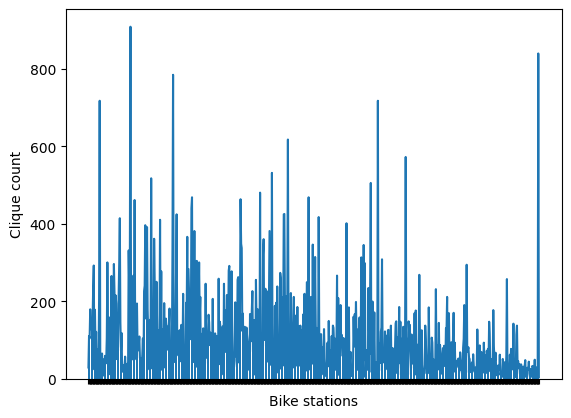

In [14]:
cliques = list(nx.find_cliques(G))

# Count the number of times each station appears in the cliques
station_counts = Counter([station for clique in cliques for station in clique])

# Get the names of the stations and their counts
stations, counts = zip(*station_counts.items())

# Create the plot
fig, ax = plt.subplots()
ax.plot(stations, counts)

# Add a description to the x-axis
ax.set_xlabel("Bike stations")
# Add a description to the y-axis
ax.set_ylabel("Clique count")

# Remove the x-axis labels
plt.gca().set_xticklabels([])

# Plot a bar chart of the station counts
plt.bar(stations, counts)
plt.show()